# Creating Electricity Spot Price predictions for SA, NSW, VIC and QLD with data from amphora.com

In [182]:
#!"./setup-EForecast.sh"
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
import numpy as np
from datetime import datetime, timezone, timedelta
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from joblib import dump, load
from modules import APIfetch
import modules.tool as tool
from keras import models
from keras.optimizers import SGD
from modules import func_CNN_1, func_CNN_2, func_NN_3
import math
import time
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

## Loading data, creating differential features, creating X, and Y data

In [293]:
params = {'id': '',
        'start_time': datetime(2019,11,9,11),#YYYY,MM,DD,hh,mm
        'end_time': datetime(2020,1,7,11),
        #'filter': ''
        }

e_ids = {'electricity_NSW': 'ecc5263e-83b6-42d6-8852-64beffdf204e',  
        'electricity_QLD': 'ef22fa0f-010c-4ab1-8a28-a8963f838ce9',  
        'electricity_VIC': '3b66da5a-0723-4778-98fc-02d619c70664', 
        'electricity_SA': '89c2e30d-78c8-46ef-b591-140edd84ddb6'}  

electricity_dict = {}
for _ in e_ids:
    params['id'] = e_ids[_]
    data_temp = APIfetch.fetch_data(params)
    
    if 'filter' in params:
        del data_temp['periodType.{}'.format(params['filter'])]
    else:
        del data_temp['periodType']

    # add the _state suffix to column names:
    data_temp.columns = [col +'_'+_[_.index('_')+1:] for col in data_temp.columns]
    data_temp = data_temp.sort_index()

    # prevent some weird pandas 'feature' from resampling the df:
    data_temp = data_temp.apply(pd.to_numeric, errors='coerce')
    electricity_dict[_] = data_temp.resample('1h').mean()

forecast_dict = {}
for _ in e_ids:
    params['filter'] = 'Forecast'
    params['id'] = e_ids[_]
    data_temp = APIfetch.fetch_data(params)
    del data_temp['periodType.Forecast']

    # add the _state suffix to column names:
    data_temp.columns = [col +'_'+_[_.index('_')+1:] for col in data_temp.columns]
    data_temp = data_temp.sort_index()

    # prevent some weird pandas 'feature' from resampling the df:
    data_temp = data_temp.apply(pd.to_numeric,                       errors='coerce')
    forecast_dict[_] = data_temp.resample('1h').mean()
    del params['filter']
    
w_ids = {'weather_NSW': '11fd3d6a-12e4-4767-9d52-03271b543c66',  
        'weather_QLD': 'a46f461f-f7ee-4cc5-a1e4-569960ea5ed8',  
        'weather_VIC': 'd48ac35f-c658-41c1-909a-f662d6f3a972', 
        'weather_SA': 'f860ba45-9dda-41e0-91aa-73901a323318'}  

weather_dict = {}
for _ in w_ids:
    params['id'] = w_ids[_]
    data_temp = APIfetch.fetch_data(params)

    if 'filter' in params:
        del data_temp['description.{}'.format(params['filter'])]
    else:
        del data_temp['description']

    # add the _state suffix to column names:
    data_temp.columns = [col +'_'+_[_.index('_')+1:] for col in data_temp.columns]
    data_temp = data_temp.sort_index()

    # prevent some weird pandas 'feature' from resampling the df:
    data_temp = data_temp.apply(pd.to_numeric,                       errors='coerce')
    weather_dict[_] = data_temp.resample('1h').mean()

In [294]:
# join all electricity data
df_elec = electricity_dict['electricity_NSW'].join(electricity_dict['electricity_QLD'])
df_elec = df_elec.join(electricity_dict['electricity_VIC'])
df_elec = df_elec.join(electricity_dict['electricity_SA'])
df_elec = tool.create_diffs(df_elec, list(range(len(df_elec.columns))))

# join all forecast data
df_fore = forecast_dict['electricity_NSW'].join(forecast_dict['electricity_QLD'])
df_fore = df_fore.join(forecast_dict['electricity_VIC'])
df_fore = df_fore.join(forecast_dict['electricity_SA'])
df_fore = tool.create_diffs(df_fore, list(range(len(df_fore.columns))))

# outer join for all weather data
df_weather = weather_dict['weather_NSW'].join(weather_dict['weather_QLD'])
df_weather = df_weather.join(weather_dict['weather_VIC'])
df_weather = df_weather.join(weather_dict['weather_SA'])
df_weather = tool.create_diffs(df_weather, list(range(len(df_weather.columns))))

In [295]:
# re-sort dataset columns and extract test data y
df_elec = df_elec.reindex(sorted(df_elec.columns), axis=1)
y = df_elec.iloc[:,8:12]
for _ in y.columns:
    del df_elec[_]

print('elec shape: ',df_elec.shape)
print('y shape: ',y.shape)

# Create complete dataset of all train variables
df_all = df_weather.join(df_elec)
df_all = df_all.join(df_fore)

print('df_all shape: ',df_all.shape)

#also atomise the datetime index, will be v useful for large-ish datasets, as spikes on e.g. weekends, become identifiable for the model:
# split dates into year month day day of week hour, etc for additional features 
df_all = tool.split_dates_df(df_all)

elec shape:  (1120, 12)
y shape:  (1120, 4)
df_all shape:  (1094, 76)


In [296]:
# ensure equal shape on both X & Y, so both train and test data share the same timeframe
df_all = df_all.interpolate(method='spline', 
                            order=3,
                            limit_direction='forward', 
                            axis=0)
df_all = df_all.dropna()
y = y.dropna()

# ensuring both are consistent:
y = y[y.index.isin(df_all.index)]
df_all = df_all[df_all.index.isin(y.index)]
y = y[y.index.isin(df_all.index)]
#y = y[(y.index>=df_all.index[0]) & (y.index<=df_all.index[-1])]
assert all(dat in df_all.index for dat in y.index), 'Index differs for df_all and y!'
y.shape

(910, 4)

In [297]:
# save data for tracking of datasets:
# now=datetime.now()
# y.to_csv(f'./2_raw_data/y-{now}.csv')
# df_all.to_csv(f'./2_raw_data/df_all-{now}.csv')

## Creating Linear, RFR, NN and CNN models:

In [298]:
##Define data ranges for train, validation, and test set:

# data the model will be trained on (corresponding columns)
train_from = 0
train_to = floor(0.9 * (df_all.shape[0] - 2))

# data the current model (read: weights) are validated on
valid_from = floor(0.9 * (df_all.shape[0] - 2))+1
valid_to = floor(0.95 * (df_all.shape[0] - 2))

# data the final fit will be tested on, to make predictions for the last timesteps
test_from = floor(0.95 * (df_all.shape[0] - 2))+1
test_to = df_all.shape[0] - 2

# the last 24h will serve for inference purposes:
inference_from = df_all.shape[0]-1
nrow = df_all.shape[0]

# create timestamps for the prediction df index:
temp_index = pd.date_range(start=(df_all.index[inference_from] + 
                                  pd.Timedelta('1 hour')),
                           freq='H',
                           periods=24)

### Fitting a multivariate linear model to the top i variables with the highest correlation to 'price_STATE':

In [299]:
# Fitting a multi linear model to the top i variables with the highest correlation to 'price_SA':

#df containing the predicted values with correct timestamps, and error list:
lin_pred_df = pd.DataFrame(index=temp_index)
mse_lin = pd.DataFrame(index=temp_index)

for timeshift in range(1,25):
    # Calculate correlations to price for slim and nimble multi-linear model
    # account for timeseries nature of problem by cutting `timeshift` rows from
    # X data, and shifting y by `timeshift` time steps:
    # thus for all points in time: 
    # df_all.iloc[a:(b-timeshift),:] 
    # y.iloc[(a+timeshift):b,:]
    corr_NSW   =  (df_all.iloc[:(nrow-timeshift),:].join(y.iloc[timeshift:,0])).corr()
    corr_QLD   =  (df_all.iloc[:(nrow-timeshift),:].join(y.iloc[timeshift:,1])).corr()
    corr_SA    =  (df_all.iloc[:(nrow-timeshift),:].join(y.iloc[timeshift:,2])).corr()
    corr_VIC   =  (df_all.iloc[:(nrow-timeshift),:].join(y.iloc[timeshift:,3])).corr()
    state_dict =  {'NSW': corr_NSW, 'QLD': corr_QLD, 'VIC': corr_VIC, 'SA': corr_SA}

    # fit for each state, calculate errors and make predictions:
    for _, counter in zip(y.columns, range(len(y.columns))):
        # extract state string:
        state = _[_.index('_')+1:]

        # test if result col already exists, if not create it:
        temp_str = ''.join([state,'_linModel-inferred'])
        if temp_str not in lin_pred_df.columns:
            lin_pred_df[temp_str] = np.nan
        if temp_str not in mse_lin.columns:
            mse_lin[temp_str] = np.nan

        # select vars with highest correlation to electricity spot price in state:
        h_corr = list(state_dict[state][_].sort_values(ascending=False)[1:20].index)

        # create training, validation and validation features:
        # ignoring validation set here as only used in NN below
        training_x = df_all[h_corr].iloc[train_from:(valid_to - timeshift),:]
        training_y = y[[_]].iloc[timeshift:valid_to,:]
        test_x = df_all[h_corr].iloc[test_from:(test_to - timeshift),:]
        test_y = y[[_]].iloc[(test_from + timeshift):test_to,:]
        
        # get the (model, test-preds for mse) from the fit:
        lin1, lin1_pred = tool.linear_model_predictions(training_x,                                             training_y,                                             test_x)

        # mean squared error and relative rror on the validation data for efficacy test:
        mse_lin.iloc[timeshift-1,counter] = tool.model_MSE(lin1_pred,                                                test_y)
    
        ## save model to folder ./5_models:
        #now = datetime.now()
        #dump(lin1, f'./5_models/{state}-lin-model-{now:y%Y-m%m-d%d-h%H-m%M}-error{mse:.1f}.joblib') # load model by using load('./folder/filename')

        # save predictions to df:
        infer = df_all[h_corr].iloc[inference_from,:]
        lin_pred_df.iloc[timeshift-1,counter] = lin1.predict(infer.values.reshape((1,len(infer))))
    
    ## ...and also save preds to csv:
    #lin_pred_df.to_csv('./6_predictions/lin-Model-predictions-{now:y%Y-m%m-d%d-h%H-m%M}.csv', header=True, index=True)

### Fitting a random forest regressor model to the data for all 'price_STATE':

In [300]:
# Fitting a Random Forest to the entire 60 variable dataset, testing for the influence of the train/test split:

# create predictions df and errors df:
RFR_pred_df = pd.DataFrame(index=temp_index)
mse_RFR = pd.DataFrame(index=temp_index)

start_time = time.time()
for timeshift in range(1,25):
    # Calculate correlations to price for slim and nimble model
    # high corr and high feature importance variables have a high overlap, so
    # as above high corr vars used for the forests
    # account for timeseries nature of problem by cutting `timeshift` rows from
    # X data, and shifting y by `timeshift` time steps:
    # thus for all points in time: 
    # df_all.iloc[a:(b-timeshift),:] 
    # y.iloc[(a+timeshift):b,:]
    corr_NSW   =  (df_all.iloc[:(nrow-timeshift),:].join(y.iloc[timeshift:,0])).corr()
    corr_QLD   =  (df_all.iloc[:(nrow-timeshift),:].join(y.iloc[timeshift:,1])).corr()
    corr_SA    =  (df_all.iloc[:(nrow-timeshift),:].join(y.iloc[timeshift:,2])).corr()
    corr_VIC   =  (df_all.iloc[:(nrow-timeshift),:].join(y.iloc[timeshift:,3])).corr()
    state_dict =  {'NSW': corr_NSW, 'QLD': corr_QLD, 'VIC': corr_VIC, 'SA': corr_SA}

    # fit for each state, calculate errors and make predictions:
    for _, counter in zip(y.columns, range(len(y.columns))):
        # extract state string:
        state = _[_.index('_')+1:]

        # test if result col already exists, if not create it:
        temp_str = ''.join([state,'_RFRModel-inferred'])
        if temp_str not in RFR_pred_df.columns:
            RFR_pred_df[temp_str] = np.nan
        if temp_str not in mse_RFR.columns:
            mse_RFR[temp_str] = np.nan

        # select vars with higher correlation to electricity spot price in state to improve preds:
        h_corr = list(state_dict[state][_].sort_values(ascending=False)[1:22].index)    
        # create train, test data (validation data is intrinsic due to oob):
        # ignoring validation set here as only used in NN below
        training_x = df_all[h_corr].iloc[train_from:(valid_to - timeshift),:]
        training_y = y[[_]].iloc[timeshift:valid_to,:]
        test_x = df_all[h_corr].iloc[test_from:(test_to - timeshift),:]
        test_y = y[[_]].iloc[(test_from + timeshift):test_to,:]

        RFR = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
        RFR.fit(training_x, np.ravel(training_y))
        RFR_pred = RFR.predict(test_x)
        
        # mean square error and relative rror on the validation data for efficacy test:
        mse_RFR.iloc[timeshift-1,counter] = tool.model_MSE(RFR_pred.reshape((len(RFR_pred),1)),test_y)

        # save predictions to predictions dataframe:
        infer = df_all[h_corr].iloc[inference_from,:]
        RFR_pred_df.iloc[timeshift-1,counter] = RFR.predict(infer.values.reshape((1,len(infer))))
        
        ## save model to folder ./5_models:
        # now = datetime.now()
        # dump(RFR, f'./5_models/{state}-timeshift{timeshift}-RFR-model-{now:y%Y-m%m-d%d-h%H-m%M}.joblib') # load model by using load('./folder/filename')

    # RFR_pred_df.to_csv('./6_predictions/RFR-Model-predictions-{now:y%Y-m%m-d%d-h%H-m%M}.csv', header=True, index=True)
    
print("--- {} seconds passed ---".format(time.time() - start_time))


In [0]:
# RFR.feature_importances_
# temp_df = pd.DataFrame()
# temp_df['feature'] = [*temp_df.iloc[:,1:16].columns]#,'testfeature']
# temp_df['importance'] = [*RFR.feature_importances_]
# temp_df.sort_values(by=['importance'], ascending=False)

#### CNN approach using multiple inputs, one output array:


In [0]:
# a bit dense, but it selects all cols containing the '_XXX' substring
# creates a list thereof, unpacks it (* unpacks), then adds others
# unnamde cols:
df_NSW = df_all[[*df_all.columns[['_NSW' in a for a in df_all.columns]],'year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_VIC = df_all[[*df_all.columns[['_VIC' in a for a in df_all.columns]],'year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_QLD = df_all[[*df_all.columns[['_QLD' in a for a in df_all.columns]],'year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_SA = df_all[[*df_all.columns[['_SA' in a for a in df_all.columns]],'year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

In [0]:
### Neural net using one input per state, returns array (len(array)=4)

# some neural net hyperparameters (hp)
batch_size = 24
epochs = 25

model_CNN = func_CNN_1.func_CNN_1(df_QLD, nn_name='model_CNN')
model_CNN.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
CNN_1_pred_df = pd.DataFrame(columns=y.columns, index=temp_index)
mse_CNN = pd.DataFrame(columns=y.columns, index=temp_index)

start_time = time.time()
for timeshift in range(1,25):
    # reshape the data to have the right tensor dimensions for the neural net:
    # which are (batch_size, steps, input_dim):
    NSW = tool.reshape_for_CNN(df_NSW)
    QLD = tool.reshape_for_CNN(df_QLD)
    VIC = tool.reshape_for_CNN(df_VIC)
    SA = tool.reshape_for_CNN(df_SA)
    test_y = y.iloc[(test_from + timeshift):test_to,:]

    # This model optimises for the mse to be minimal testing model efficacy on
    # validation data to check over-/underfitting:
    history = model_CNN.fit([NSW[0:(train_to-timeshift),:],
                     QLD[0:(train_to-timeshift),:],
                     VIC[0:(train_to-timeshift),:],
                     SA[0:(train_to-timeshift),:]],
                     y.iloc[timeshift:train_to,:],
          validation_data=([NSW[valid_from:(valid_to-timeshift),:],
           QLD[valid_from:(valid_to-timeshift),:], 
           VIC[valid_from:(valid_to-timeshift),:], 
           SA[valid_from:(valid_to-timeshift),:]],
           y.iloc[(valid_from+timeshift):valid_to,:]),
          batch_size=batch_size,
          epochs=epochs,
          verbose=0)

    # create predictions for mse calculation:
    predictions = model_CNN.predict([NSW[test_from:(test_to-timeshift),:],
                                QLD[test_from:(test_to-timeshift),:],
                                VIC[test_from:(test_to-timeshift),:],
                                SA[test_from:(test_to-timeshift),:]])

    # save predictions to predictions dataframe, need to be reshaped for right dims:
    dim = NSW[inference_from].shape[0]
    CNN_1_pred_df.iloc[timeshift-1,:] = model_CNN.predict([NSW[inference_from].reshape((1,dim,1)),
                                            QLD[inference_from].reshape((1,dim,1)),
                                            VIC[inference_from].reshape((1,dim,1)),
                                            SA[inference_from].reshape((1,dim,1))])

    # mean square error on the validation data for efficacy test:
    mse_CNN.iloc[timeshift-1,:] = tool.MSE_CNN(predictions,test_y)[0]
    
    ## save model to folder ./5_models:
    # now = datetime.now()
    # model_CNN.save(f'./5_models/CNN_1-model-epochs{epochs}-{now:y%Y-m%m-d%d-h%H-m%M}.h5')
    # load model by using: 
    # models.load_model('./5_models/CNN_1-model-y2019-m12-d17-h09-m20.h5')

print("--- {} seconds passed ---".format(time.time() - start_time))

# save predictions:
# CNN_1_pred_df.to_csv(f'./6_predictions/CNN_1-Model-predictions-epochs{epochs}-{now:y%Y-m%m-d%d-h%H-m%M}.csv', header=True, index=True)

#### 2$^{nd}$ CNN model taking all inputs into consideration, optimising for each state individually, also factoring in time-like nature of problem in a causal manner:

In [0]:
# define model, separate losses per state,
model_CNN_2 = func_CNN_2.func_CNN_2(df_all, nn_name='model_CNN_2')
losses = {'NSW': 'mse',
          'QLD': 'mse',
          'VIC': 'mse',
          'SA': 'mse'}
metric = {'NSW': 'mse',
          'QLD': 'mse',
          'VIC': 'mse',
          'SA': 'mse'}
# compile model with the aboce losses, mse as it penalises larger errors more
model_CNN_2.compile(loss=losses, optimizer='adam', metrics=metric)
CNN_2_pred_df = pd.DataFrame(columns=y.columns, index=temp_index)
mse_CNN_2 = pd.DataFrame(columns=y.columns, index=temp_index)

# define some hyper parameters:
batch_sizes = 24
epochs = 31

# create the right tensor shape to feed into a convolutional-nn-layer:
input_data = tool.reshape_for_CNN(df_all)

# fit model to data:
start_time = time.time()

for timeshift in range(1,25):
    t_train = {'NSW': y.iloc[train_from:train_to,0],
        'QLD': y.iloc[train_from:train_to,1],
        'SA': y.iloc[train_from:train_to,2],
        'VIC': y.iloc[train_from:train_to,3]}
    t_valid = {'NSW': y.iloc[valid_from:valid_to,0],
               'QLD': y.iloc[valid_from:valid_to,1],
               'SA': y.iloc[valid_from:valid_to,2],
               'VIC': y.iloc[valid_from:valid_to,3]}
    test_y = y.iloc[(test_from + timeshift):test_to,:]

    history_2 = model_CNN_2.fit(input_data[train_from:train_to,:],
                t_train,
                validation_data=(input_data[valid_from:valid_to,:],
                t_valid),
                batch_size=batch_sizes,
                epochs=epochs,
                shuffle=False,
                verbose=0)

    # create predictions for test data: 
    in_ = input_data[test_from:(test_to-timeshift),:]
    predictions_2 = np.array(model_CNN_2.predict(in_)).reshape(in_.shape[0],4)
    
    # save predictions to predictions dataframe, need to be reshaped for right dims:
    dim = input_data[inference_from].shape[0]
    in_2 = input_data[inference_from,:].reshape((1,dim,1))
    CNN_2_pred_df.iloc[timeshift-1,:] = np.array(model_CNN_2.predict(in_2)).reshape(4)

    # mean square error on the validation data for efficacy test:
    mse_CNN_2.iloc[timeshift-1,:] = tool.MSE_CNN(predictions_2,test_y)[0]

print("--- {} seconds passed ---".format(time.time() - start_time))

# # save model to folder ./5_models:
# now = datetime.now()
# model_CNN.save(f'./5_models/CNN_2-model-epochs{epochs}-{now:y%Y-m%m-d%d-h%H-m%M}.h5')
# # load model by using: 
# # models.load_model('./5_models/CNN_2-model-y2019-m12-d17-h09-m20.h5')


# CNN_2_pred_df.to_csv(f'./6_predictions/CNN_2-Model-predictions-epochs{epochs}-{now:y%Y-m%m-d%d-h%H-m%M}.csv', header=True, index=True)

In [0]:
# define model, separate losses per state,
model_NN_3 = func_NN_3.func_NN_3(df_all, nn_name='model_NN_3')
losses = {'NSW': 'mse',
          'QLD': 'mse',
          'VIC': 'mse',
          'SA': 'mse'}
metric = {'NSW': ['mse'],
          'QLD': ['mse'],
          'VIC': ['mse'],
          'SA': ['mse']}          
RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9)

# compile model with the aboce losses, rmse as it penalises larger errors more
model_NN_3.compile(loss=losses, optimizer=RMSprop, metrics=metric)
NN_3_pred_df = pd.DataFrame(columns=y.columns, index=temp_index)
mse_NN_3 = pd.DataFrame(columns=y.columns, index=temp_index)

# define some hyper parameters:
batch_sizes = 96
epochs = 23

# fit model to data:
start_time = time.time()

for timeshift in range(1,25):
    t_train = {'NSW': y.iloc[train_from:train_to,0],
                 'QLD': y.iloc[train_from:train_to,1],
                 'SA': y.iloc[train_from:train_to,2],
                 'VIC': y.iloc[train_from:train_to,3]}
    t_valid = {'NSW': y.iloc[valid_from:valid_to,0],
                 'QLD': y.iloc[valid_from:valid_to,1],
                 'SA': y.iloc[valid_from:valid_to,2],
                 'VIC': y.iloc[valid_from:valid_to,3]}
    test_y = y.iloc[(test_from + timeshift):test_to,:]

    history_3 = model_NN_3.fit(df_all.iloc[train_from:train_to,:], 
                t_train,
                validation_data=(df_all.iloc[valid_from:valid_to,:],
                                 t_valid),
                batch_size=batch_sizes,
                epochs=epochs,
                shuffle=False,
                verbose=0)

    # create predictions for test data: 
    in_ = df_all.iloc[test_from:(test_to-timeshift),:]
    predictions_3 = np.array(model_NN_3.predict(in_))
    predictions_3 = predictions_3.reshape(in_.shape[0],4)
    
    # save predictions to predictions dataframe, need to be reshaped for right dims:
    dim = df_all.iloc[inference_from,:].shape[0]
    in_2 = np.array(df_all.iloc[inference_from,:]).reshape(1,dim)
    NN_3_pred_df.iloc[timeshift-1,:] = np.array(model_NN_3.predict(in_2)).reshape(4)
    
    # mean square error on the validation data for efficacy test:
    mse_NN_3.iloc[timeshift-1,:] = tool.MSE_CNN(predictions_3,
                                                 test_y)[0]
    

print("--- {} seconds passed ---".format(time.time() - start_time))

    
# # save model to folder ./5_models:
# now = datetime.now()
# model_NN_3.save(f'./5_models/NN_3-model-epochs{epochs}-{now:y%Y-m%m-d%d-h%H-m%M}.h5')
# # load model by using: 
# # models.load_model('./5_models/NN_3-model-y2019-m12-d17-h09-m20.h5')



# NN_3_pred_df.to_csv(f'./6_predictions/CNN_3-Model-predictions-epochs{epochs}-{now:y%Y-m%m-d%d-h%H-m%M}.csv', header=True, index=True)

In [0]:
# get all the mean abs errors, select smallest, use model to make inferences:
mse_arr = [mse_lin['SA_linModel-inferred'].mean(), 
    mse_RFR['SA_RFRModel-inferred'].mean(), 
    mse_CNN['price_SA'].mean(), 
    mse_CNN_2['price_SA'].mean(), 
    mse_NN_3['price_SA'].mean()]

# get index of minimal member of list:
index_min = min(range(len(mse_arr)), key=mse_arr.__getitem__)

# get best predictions:
pred_list = [lin_pred_df, RFR_pred_df, CNN_1_pred_df, CNN_2_pred_df, NN_3_pred_df]
inference = pred_list[index_min]
inference.columns = [(_[_.index('_')+1:]).lower() for _ in y.columns ]

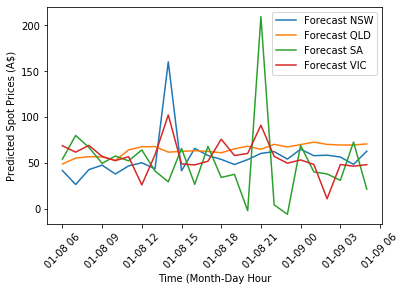

In [292]:
#plt.yscale('log')
plt.plot(inference.index, inference.iloc[:,0])
plt.plot(inference.index, inference.iloc[:,1])
plt.plot(inference.index, inference.iloc[:,2])
plt.plot(inference.index, inference.iloc[:,3])
plt.xticks(rotation=45)
plt.ylabel('Predicted Spot Prices (A$)')
plt.xlabel('Time (Month-Day Hour')
plt.legend([f'Forecast {inference.columns[0].upper()}',
            f'Forecast {inference.columns[1].upper()}',
            f'Forecast {inference.columns[2].upper()}',
            f'Forecast {inference.columns[3].upper()}'],
             loc='best')

In [0]:
np.sqrt(mse_CNN['price_SA'].mean())

In [268]:
params = {'name': "Electricity Spot Prices",
        'description': "Trends for electricity spot prices. Absolute value may diverge from true value, but trend is valid.",
        'price': 0
        }
 
# upload        
APIfetch.upload_series(inference, params, id_='3a2ad59f-4995-4375-87a4-c05da3537307')

ValueError: Invalid value for `username`, must not be `None`

In [0]:
# now = datetime.now()
# inference.to_csv(f'./6_predictions/Model-predictions-{now:y%Y-m%m-d%d-h%H-m%M}.csv', header=True, index=True)